# AMEX Default Prediction
## Featuring Engineering
* Este notebook reune el código con el que transformamos el dataset de AMEX. Selección de características con Lasso

In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [31]:
#Cargamos el dataset de entrenamiento
train = pd.read_feather('/Users/usuario/workspace/AMEX_data/train_data.ftr')
train.head(2)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0


El conjunto de datos contiene características de perfil agregadas para cada cliente en cada fecha de estado de cuenta. Las features están anonimizadas y normalizadas. Estas se clasifican en las siguientes categorías generales:

* D_* = Variables de morosidad
* S_* = Variables de gasto
* P_* = Variables de pago
* B_* = Variables de balance
* R_* = Variables de riesgo

In [32]:
%%time
# Conservamos el último registro de cada usuario
df =  (train
            .groupby('customer_ID')
            .tail(1)
            .set_index('customer_ID', drop=True)
            .sort_index()
            .drop(['S_2'], axis='columns'))

CPU times: user 6.2 s, sys: 7.45 s, total: 13.6 s
Wall time: 22.6 s


In [5]:
#df = train.copy()

In [33]:
df = df.dropna(axis=1, thresh=int(df.shape[0])*0.8)

In [34]:
df = df.dropna(axis=0, thresh=int(df.shape[1])*0.8)

In [36]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, f_regression

X = df
y = X.pop('target')
X.shape

(456647, 154)

In [65]:
all_cols = X.columns.to_list()

cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_68']

num_cols = [col for col in all_cols if col not in cat_cols + ['customer_ID', "target"]]

## Imputo con la mediana los valores numéricos faltantes

In [43]:
from sklearn.impute import SimpleImputer
imp_median = SimpleImputer(strategy='median')
imp_median.fit(X[num_cols])

SimpleImputer(strategy='median')

In [62]:
Xnum = pd.DataFrame(imp_median.transform(X[num_cols]))
Xnum.set_axis(list(X[num_cols].columns), axis=1, inplace=True)

## Transformo las features categoricas: imputo Nan con la moda y aplico one hot encoding

In [66]:
imp_mode = SimpleImputer(strategy='most_frequent')
imp_mode.fit(X[cat_cols])

SimpleImputer(strategy='most_frequent')

In [67]:
Xcat = pd.DataFrame(imp_mode.transform(X[cat_cols]))

In [73]:
onehot = OneHotEncoder(handle_unknown='ignore', drop='first')
onehot.fit(Xcat)

OneHotEncoder(drop='first', handle_unknown='ignore')

In [82]:
XcatEncoded = onehot.transform(Xcat)


In [87]:
import scipy.sparse
XcatEncoded2 = pd.DataFrame.sparse.from_spmatrix(XcatEncoded)
XcatEncoded2.set_axis(onehot.get_feature_names(list(Xcat.columns)), axis=1, inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Uno las columnas numéricas y las categóricas encodeadas en un nuevo dataframe 

In [90]:
dfnew = pd.concat([Xnum, XcatEncoded2], axis=1)

In [96]:
dfnew.shape

(456647, 175)

## Seleccionamos características relevantes con Lasso

In [151]:
# Importamos Lasso CV
import time
from sklearn.linear_model import LassoCV
t1 = time.time()
# Ajustamos el modelo mediante Cross-Validation
lasso = LassoCV(cv=25, random_state=1234).fit(dfnew, y)
t_lasso_cv = time.time() - t1

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


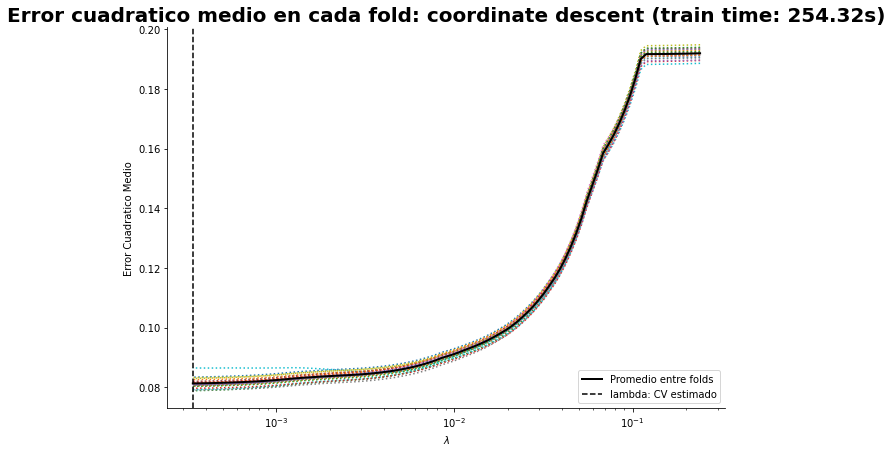

In [152]:
# Graficamos

EPSILON = 1e-4

fig, ax =plt.subplots(figsize=(10,7))
plt.semilogx(lasso.alphas_ + EPSILON, lasso.mse_path_, ':')
l1 =plt.plot(lasso.alphas_ + EPSILON, lasso.mse_path_.mean(axis=-1), 'k',
         label='Promedio entre folds', linewidth=2)
ax.axvline(lasso.alpha_ + EPSILON, linestyle='--', color='k',
            label='lambda: CV estimado')

ax.legend(fontsize=10)

ax.set_xlabel(r'$\lambda$', fontsize=10)
ax.set_ylabel('Error Cuadratico Medio', fontsize=10)
ax.set_title('Error cuadratico medio en cada fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv, fontweight='bold', fontsize=20)
plt.xticks(fontsize = 10 )
plt.yticks( fontsize = 10 )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [153]:
print(f"El lambda final obtenido mediante CV es: {lasso.alpha_}" )

El lambda final obtenido mediante CV es: 0.000239321525971922


In [155]:
coeficientes_finales = pd.DataFrame([np.array(dfnew.columns.tolist()),lasso.coef_]).T
coeficientes_finales.columns = ['feature','coeficiente']
coeficientes_finales

,feature,coeficiente
0,P_2,-0.294365
1,D_39,0.058924
2,B_1,0.102248
3,B_2,-0.068545
4,R_1,0.071608
...,...,...
170,D_68_2.0,0.0
171,D_68_3.0,0.000392
172,D_68_4.0,0.0
173,D_68_5.0,-0.004201


In [156]:
print(f"El modelo final cuenta con : {coeficientes_finales[coeficientes_finales['coeficiente']!=0].shape[0]}",' features' )

El modelo final cuenta con : 118  features


In [163]:
df_lasso = dfnew[list(coeficientes_finales[coeficientes_finales['coeficiente']!=0]['feature'])]

In [169]:
len(list(coeficientes_finales[coeficientes_finales['coeficiente']!=0]['feature']))

118

In [170]:
df_lasso.set_axis(list(coeficientes_finales[coeficientes_finales['coeficiente']!=0]['feature']), axis=1, inplace=True)
df_lasso.set_axis(list(pd.DataFrame(y).index), axis=0, inplace=True)
df_lasso = pd.concat([df_lasso, y], axis=1)
df_lasso

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_44,B_4,...,D_117_6.0,D_120_1.0,D_126_1.0,D_63_CO,D_64_O,D_64_R,D_68_3.0,D_68_5.0,D_68_6.0,target
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.934570,0.009117,0.009384,1.007812,0.006104,0.135010,0.001604,0.007175,0.003258,0.070801,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.880371,0.178101,0.034698,1.003906,0.006912,0.165527,0.005550,0.005070,0.008781,0.020630,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.880859,0.009705,0.004284,0.812500,0.006451,0.164795,0.003796,0.007195,0.000628,0.031052,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.621582,0.001082,0.012566,1.005859,0.007828,0.287842,0.004532,0.009941,0.007793,0.007236,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.872070,0.005573,0.007679,0.815918,0.001247,0.164795,0.000231,0.005527,0.002436,0.269287,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0.844238,0.447510,0.028519,1.009766,0.001928,0.128662,0.003483,0.005894,0.002281,0.058319,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0.831055,0.033661,0.292480,0.055664,0.006954,0.164795,0.005791,0.233032,0.132202,0.248413,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0.800293,0.267090,0.020569,1.006836,0.000957,0.066650,0.007423,0.006313,0.001022,0.079590,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145b2c3d01967fcce461,0.753906,0.008621,0.015839,0.714355,0.000993,0.408936,0.003391,0.050049,0.133057,0.237427,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1


In [171]:
df_lasso.to_csv('/Users/usuario/workspace/AMEX_data/train_data_LASSO2_transformed.csv')

## Método select from model

In [158]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.000239321525971922, penalty="l1", dual=False).fit(dfnew, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(dfnew)
X_new.shape

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:758: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


(456647, 46)

In [159]:
X_new = pd.DataFrame(X_new)
X_new.set_axis(list(model.get_feature_names_out(list(dfnew.columns))), axis=1, inplace=True)
X_new.set_axis(list(pd.DataFrame(y).index), axis=0, inplace=True)
X_new2 = pd.concat([X_new, y], axis=1)

In [162]:
X_new2.to_csv('/Users/usuario/workspace/AMEX_data/train_data_LASSO_transformed.csv')